# Double DQN 仕様変更の確認


<div class="notebook-data">
<div class="author">Ogawa</div>
<div class="company">GRID</div>
<div class="date">2019/1/25</div>
<div class="description">
</div>
</div>

## Conclusion

DDQN logger successful.

## Required libraries
- ReNom 2.6.2


In [1]:
import gym
import numpy as np
import renom as rm

import matplotlib.pyplot as plt

from renom_rl.discrete.double_dqn import DoubleDQN
from old.double_dqn import DoubleDQN as DoubleDQN_old
from renom_rl.environ.env import BaseEnv
from renom_rl.utility.filter import EpsilonEIFilter
from renom_rl.utility import Animation

## Class definition
We create a class of the environment of MountainCar. By default, $ -1 $ is given at every step as the reward until task completion. However, the learning does not proceed well with this reward because negative rewards are given to all actions until the task is completed. Here, we define the reward as the coordinate (horizontal position) of the car.

In [2]:
from copy import deepcopy

class MountainCar(BaseEnv):
    
    def __init__(self):
        self.env = gym.make('MountainCar-v0') 
        self.action_shape = (self.env.action_space.n,)
        self.state_shape = self.env.observation_space.shape
        print("Env Space : ", self.state_shape)
        print("Action Space : ", self.action_shape)
        
        self.animation = Animation()
        self.test_mode = False
    
    def reset(self):
        return self.env.reset()
    
    def sample(self):
        return self.env.action_space.sample()
    
    def step(self, action):
        state, _, terminal, _ = self.env.step(int(action))
        reward = 0
        
        if terminal:
            if state[0] > 0.5:
                reward = 1
            else:
                reward = state[0] + 0.5
         
        return state, reward, terminal
    
    def test_start(self):
        self.animation.reset()
        self.env.reset()
    
    def test_epoch_step(self):
        self.animation.store(self.env.render(mode="rgb_array"))
    
    def test_close(self):
        self.env.close() 
        self.env.viewer = None
                
env = MountainCar()

env2=deepcopy(env)

q_network = rm.Sequential([ rm.Dense(30),
                           rm.Relu(),
                           rm.Dense(30),
                           rm.Relu(),
                           rm.Dense(env.action_shape[0])
                            ])

q_network2 = deepcopy(q_network)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Env Space :  (2,)
Action Space :  (3,)


/Users/mikeogawa/gym/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
/Users/mikeogawa/gym/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


## Learning    

In [3]:
fil = EpsilonEIFilter(min=0, max=1.0, alpha=0.1)

agent2 = DoubleDQN(env2, q_network2)

agent2.fit(epoch=2, 
          epoch_step=5000, 
          batch_size=100, 
          update_period=40, 
          action_filter=fil,
          random_step=100)

epoch 0001 epsilon 1.0000 loss 0.0038 rewards in epoch 0.000 episode 0000 rewards in episode 0.000.:   0%|          | 24/5000 [00:00<00:30, 163.57it/s]

Run random 100 step for storing experiences


epoch 001 avg_loss:0.0002 total reward in epoch: [train:-0.130 test:0.115] avg train reward in episode:-0.005 epsilon :0.294: 100%|██████████| 5000/5000 [00:40<00:00, 123.01it/s]
epoch 002 avg_loss:0.0002 total reward in epoch: [train:-1.605 test:-0.229] avg train reward in episode:-0.062 epsilon :0.169: 100%|██████████| 5000/5000 [00:38<00:00, 130.27it/s]


In [4]:
fil = EpsilonEIFilter(min=0, max=1.0, alpha=0.3)

agent = DoubleDQN_old(env, q_network)

agent.fit(epoch=2, 
          epoch_step=5000, 
          batch_size=100, 
          update_period=40, 
          action_filter=fil,
          random_step=100)

epoch 0001 epsilon 1.0000 loss 0.0002 rewards in epoch 0.000 episode 0000 rewards in episode 0.000.:   1%|          | 29/5000 [00:00<00:30, 161.63it/s]

Run random 100 step for storing experiences


epoch 001 avg_loss:0.0000 total reward in epoch: [train:0.905 test:0.166] avg train reward in episode:0.036 e-greedy:0.122: 100%|██████████| 5000/5000 [00:38<00:00, 128.35it/s]
epoch 002 avg_loss:0.0000 total reward in epoch: [train:0.634 test:-0.229] avg train reward in episode:0.025 e-greedy:0.064: 100%|██████████| 5000/5000 [00:38<00:00, 130.17it/s]


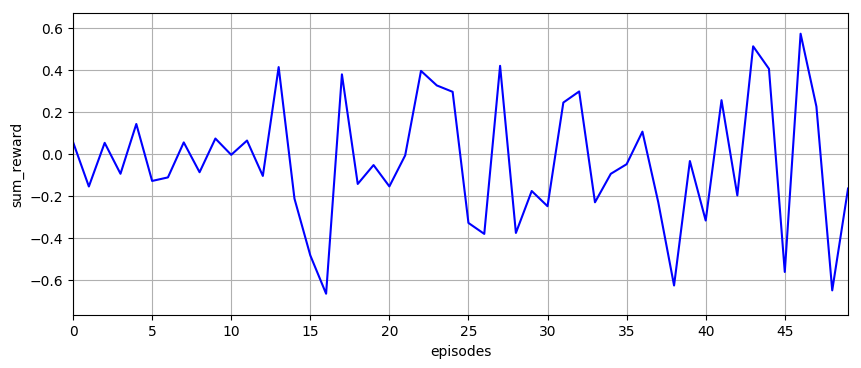

In [7]:
agent2.logger.graph("sum_reward",x_interval=5,figsize=(10,4))

## Visualizing the learned agent

In [ ]:
# print('reward of one episode is ', agent.test(test_step=None))
# env.animation.run()
# q_network.save("ddqn_mountaincar.h5")